# Regression model for metadata

In [24]:
import pandas as pd
import numpy as np
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import matplotlib.pyplot as plt

### Loading the data

In [25]:
y_metrics = pd.read_csv("../../reports/tot_loss_lstm.csv", index_col=0)["normalized_rmse"]
Y = y_metrics
x_metrics = pd.read_csv("../../data/raw/meta_data.csv", index_col=1).iloc[:, 1:]

In [27]:
exog = [
    "fullTimeEmployees",
    "overallRisk", 
    "dividendYield", 
    "marketCap", 
    "shortRatio", 
    "heldPercentInsiders", 
    "heldPercentInstitutions", 
    "numberOfAnalystOpinions"
]
X = x_metrics[exog]

In [28]:
tickers = y_metrics.index
X = X.loc[tickers, :]
X = add_constant(X)

### Some cleaning

In [29]:
too_high_error_tickers = Y[Y >= 5].index
X = X.drop(too_high_error_tickers)
Y = Y.drop(too_high_error_tickers)

X.loc[:, "dividendYield"] = X["dividendYield"].replace(np.nan, 0)
X.loc[:, "numberOfAnalystOpinions"] = X["numberOfAnalystOpinions"].replace(np.nan, 0)
X.loc[:, "overallRisk"] = X["overallRisk"].replace(np.nan, X["overallRisk"].mean())

In [ ]:
tickers_to_drop = X.isna().sum(axis=1).astype(bool)
X = X[~tickers_to_drop]
Y = Y[~tickers_to_drop]

In [31]:
# Ensure you have no nan-values
X.isna().sum()

const                      0
fullTimeEmployees          0
overallRisk                0
dividendYield              0
marketCap                  0
shortRatio                 0
heldPercentInsiders        0
heldPercentInstitutions    0
numberOfAnalystOpinions    0
dtype: int64

### Save the data

In [ ]:
X.to_csv("../../data/processed/X_regression.csv")
Y.to_csv("../../data/processed/Y_regression.csv")

### OLS

In [32]:
model = OLS(Y, X)
result = model.fit(cov_type='HC3')
result.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 7
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        normalized_rmse   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                    0.4976
Date:                Thu, 28 Nov 2024   Prob (F-statistic):              0.830
Time:                        11:53:47   Log-Likelihood:               -0.10119
No. Observations:                  44   AIC:                             18.20
Df Residuals:                      35   BIC:                             34.26
Df Model:                           8                                         
Covariance Type:                  HC3                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.0021      0.250      4.009      0.000       0.512       1.492
fullTimeEmployees       -2.747e-06   3.63e-06     -0.757      0.449   -9.86e-06    4.37e-06
overallRisk                 0.0183      0.025      0.736      0.462      -0.031       0.067
dividendYield               4.9093      4.727      1.039      0.299      -4.355      14.174
marketCap                1.273e-12   3.41e-12      0.374      0.709   -5.41e-12    7.95e-12
shortRatio                  0.0006      0.012      0.046      0.963      -0.023       0.024
heldPercentInsiders         0.3027      0.889      0.340      0.734      -1.440       2.046
heldPercentInstitutions     0.1282      0.266      0.482      0.630      -0.393       0.649
numberOfAnalystOpinions    -0.0138      0.011     -1.290      0.197      -0.035       0.007
==============================================================================
Omnibus:                       16.143   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.337
Skew:                           1.211   Prob(JB):                     3.84e-05
Kurtosis:                       5.287   Cond. No.                     1.20e+12
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.2e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

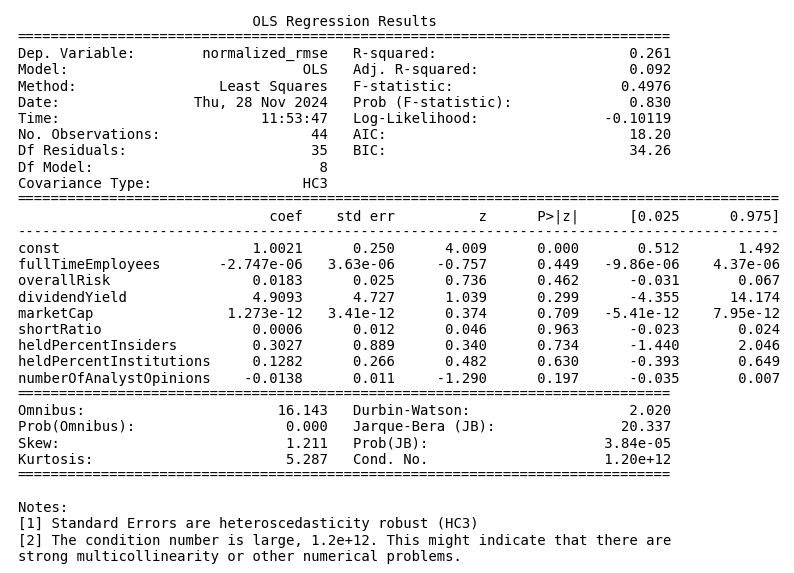

In [33]:
summary_text = result.summary().as_text()

# Render the summary as a PNG
plt.figure(figsize=(10, 6))
plt.text(0.01, 0.99, summary_text, fontsize=10, family='monospace', verticalalignment='top')
plt.axis('off')

# Save as PNG
plt.savefig("model_summary.png", dpi=300, bbox_inches='tight')
plt.show()

## Lasso

In [42]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Fit the Lasso regression model
lasso = Lasso(alpha=0.1)  # Adjust alpha for regularization strength
lasso.fit(X, Y)

# Predict on the test set
Y_pred = lasso.predict(X)

# Model evaluation
mse = mean_squared_error(Y, Y_pred)
r2 = r2_score(Y, Y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Summary of coefficients
print("Lasso Coefficients:")
print(lasso.coef_)


Mean Squared Error: 0.06942854192415585
R^2 Score: 0.12723095566002907
Lasso Coefficients:
[ 0.00000000e+00 -3.07287453e-06  0.00000000e+00  0.00000000e+00
  1.20902330e-12 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -1.15826060e-02]


In [56]:
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Fit the Lasso regression model
lasso = Lasso(alpha=0.1)  # Adjust alpha for regularization strength
lasso.fit(X, Y)

# Predict on the test set
Y_pred = lasso.predict(X)

# Model evaluation
mse = mean_squared_error(Y, Y_pred)
r2 = r2_score(Y, Y_pred)

# Create a summary DataFrame for coefficients
coef_summary = pd.DataFrame({
    "Feature": X.columns,#[col for col in X.columns],  # Assuming feature names as X1, X2, etc.
    "Coefficient": lasso.coef_
})
coef_summary = coef_summary[coef_summary["Coefficient"] != 0]  # Optional: Filter non-zero coefficients

# Print summary
print("Lasso Regression Summary")
print("="*40)
print(f"Alpha (Regularization Strength): {lasso.alpha}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-Squared (R2): {r2:.4f}")
print("\nCoefficients:")
print(coef_summary.to_string(index=False))


Lasso Regression Summary
Alpha (Regularization Strength): 0.1
Mean Squared Error (MSE): 0.0694
R-Squared (R2): 0.1272

Coefficients:
                Feature   Coefficient
      fullTimeEmployees -3.072875e-06
              marketCap  1.209023e-12
numberOfAnalystOpinions -1.158261e-02


In [54]:
features = coef_summary.Feature

In [55]:
model = OLS(Y, X[features])
result = model.fit(cov_type='HC3')
result.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        normalized_rmse   R-squared (uncentered):                   0.793
Model:                            OLS   Adj. R-squared (uncentered):              0.767
Method:                 Least Squares   F-statistic:                              31.82
Date:                Thu, 28 Nov 2024   Prob (F-statistic):                    8.36e-12
Time:                        12:43:40   Log-Likelihood:                         -35.996
No. Observations:                  44   AIC:                                      81.99
Df Residuals:                      39   BIC:                                      90.91
Df Model:                           5                                                  
Covariance Type:                  HC3                                                  
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
fullTimeEmployees        6.106e-06   1.06e-05      0.578      0.563   -1.46e-05    2.68e-05
overallRisk                 0.1348      0.036      3.704      0.000       0.063       0.206
marketCap               -4.044e-12   1.36e-11     -0.298      0.766   -3.07e-11    2.26e-11
shortRatio                  0.0339      0.050      0.673      0.501      -0.065       0.133
numberOfAnalystOpinions     0.0196      0.026      0.753      0.452      -0.031       0.071
==============================================================================
Omnibus:                        5.808   Durbin-Watson:                   1.699
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                7.661
Skew:                           0.169   Prob(JB):                       0.0217
Kurtosis:                       5.016   Cond. No.                     7.89e+09
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC3)
[3] The condition number is large, 7.89e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""